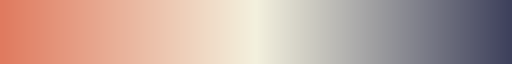

In [1]:
from scipy import odr
import matplotlib as mpl
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import gridspec
import matplotlib.colors as mcolors
import plotly.express as px, plotly.graph_objects as go
import os
import seaborn as sns
from matplotlib.colors import to_rgba

pd.options.mode.chained_assignment = None
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.size'] = 13  
colors = ["#e07a5f", "#f4f1de", "#3d405b"]
custom_cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", colors)
custom_cmap

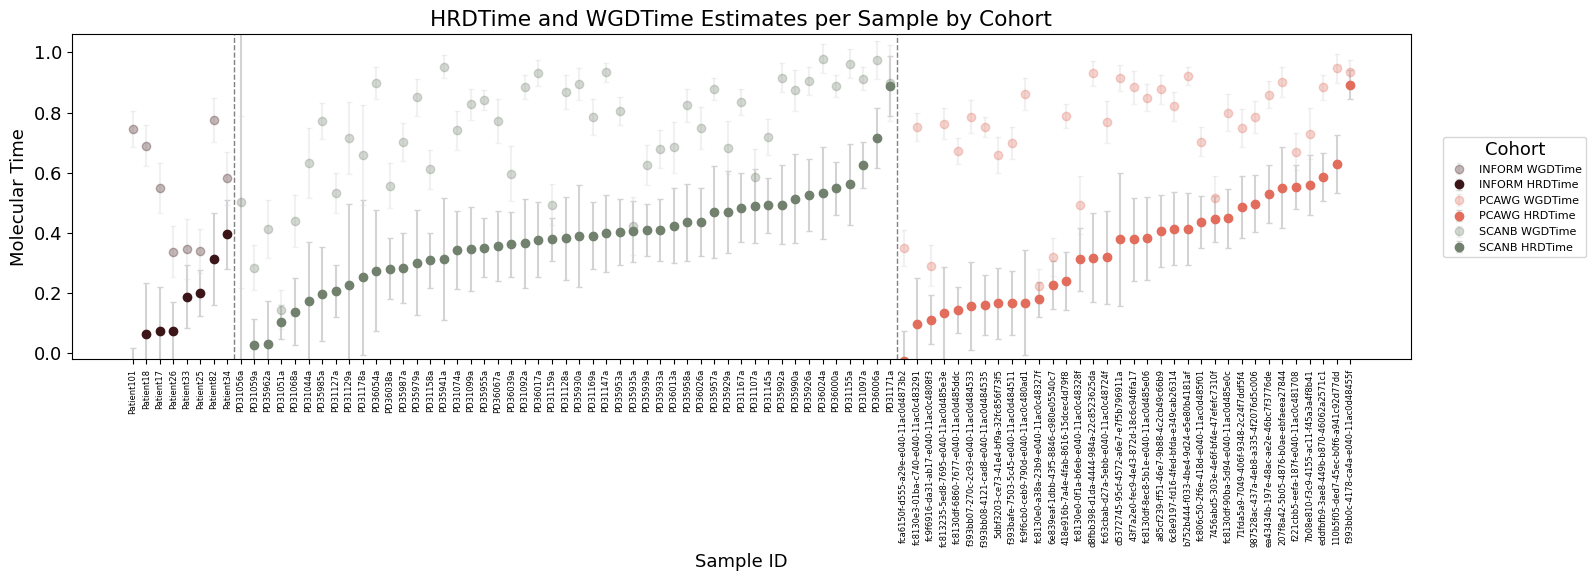

In [3]:
files = {
    'INFORM': "INFORM_germline_filtered_Breast_WGD_HRD_TimingResults_v9_timing_nboot200.csv",
    'SCANB': "SCANB_unfiltered_Breast_WGD_HRD_TimingResults_v9_timing_nboot200.csv",
    'PCAWG': "PCAWG_Breast_WGD_HRD_TimingResults_v9_timing_nboot200.csv"
}

colors = {'INFORM': '#3c1518', 'SCANB': '#71816d', 'PCAWG': '#e26d5c'}
x_pos, cohort_boundaries, dfs = 0, [], []

for k, f in files.items():
    df = pd.read_csv(f)[['ID', 'HRDTime', 'HRDTime_ci', 'WGDTime', 'WGDTime_ci']].dropna()
    df = df.sort_values('HRDTime').reset_index(drop=True)
    df['Dataset'], df['x'] = k, range(x_pos, x_pos + len(df))
    x_pos += len(df)
    cohort_boundaries.append(x_pos)
    dfs.append(df)

df_all = pd.concat(dfs, ignore_index=True)

plt.figure(figsize=(18, 6))
for k, g in df_all.groupby('Dataset'):
    plt.errorbar(g['x'], g['WGDTime'], yerr=g['WGDTime_ci'], fmt='o', color=colors[k], ecolor='lightgrey', alpha=0.3, capsize=2, label=f"{k} WGDTime")
    plt.errorbar(g['x'], g['HRDTime'], yerr=g['HRDTime_ci'], fmt='o', color=colors[k], ecolor='lightgrey', capsize=2, label=f"{k} HRDTime")

for b in cohort_boundaries[:-1]:
    plt.axvline(x=b - 0.5, color='grey', linestyle='--', linewidth=1)

plt.xticks(df_all['x'], df_all['ID'], rotation=90, fontsize=6)
plt.ylim(-0.02, 1.06)
plt.ylabel("Molecular Time")
plt.xlabel("Sample ID")
plt.title("HRDTime and WGDTime Estimates per Sample by Cohort")
plt.tight_layout(rect=[0, 0, 0.8, 1])
plt.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=8, title="Cohort")
plt.show()


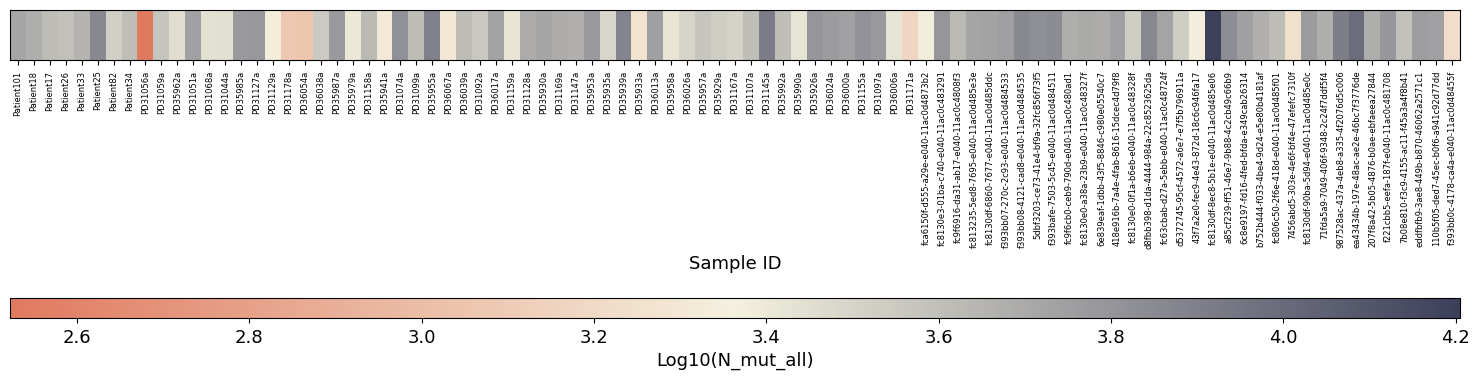

In [4]:
colors = {'INFORM': '#3c1518', 'SCANB': '#71816d', 'PCAWG': '#e26d5c'}

def parse_list(s):
    try: return np.array(eval(s, {"nan": np.nan}), dtype=float)
    except: return np.array([np.nan])

sorted_dfs, cohort_boundaries, x_pos = [], [], 0

for k, f in files.items():
    df = pd.read_csv(f)[['ID', 'HRDTime', 'HRDTime_ci', 'WGDTime', 'WGDTime_ci', 'N_mut_all']].dropna()
    df['N_mut_all_sum'] = df['N_mut_all'].apply(parse_list).apply(np.nansum)
    df = df.sort_values('HRDTime').reset_index(drop=True)
    df['Dataset'], df['x'] = k, range(x_pos, x_pos + len(df))
    x_pos += len(df)
    cohort_boundaries.append(x_pos)
    sorted_dfs.append(df)

df_all = pd.concat(sorted_dfs, ignore_index=True)

norm = mcolors.Normalize(vmin=np.log10(df_all['N_mut_all_sum'].min() + 1), vmax=np.log10(df_all['N_mut_all_sum'].max()))
fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(111)

for _, row in df_all.iterrows():
    ax.add_patch(plt.Rectangle((row['x'] - 0.5, 0), 1, 1, color=custom_cmap(norm(np.log10(row['N_mut_all_sum'] + 1))), linewidth=0))

ax.set_xlim(-0.5, len(df_all) - 0.5)
ax.set_ylim(0, 1)
ax.set_yticks([])
ax.set_xticks(df_all['x'])
ax.set_xticklabels(df_all['ID'], rotation=90, fontsize=6)
ax.set_xlabel("Sample ID")

sm = plt.cm.ScalarMappable(cmap=custom_cmap, norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=ax, orientation='horizontal', pad=0.7, aspect=70).set_label("Log10(N_mut_all)")

plt.tight_layout()
plt.show()